In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import self-implemented torch dataset
from datasets import ESCDataset

## Now training and testing on ESC-10

In [2]:
train_data = ESCDataset(root='ESC50', 
                        esc50=False, 
                        val_fold=4,
                        train=True,
                        download=True)
valid_data = ESCDataset(root='ESC50', 
                        esc50=False, 
                        val_fold=4,
                        train=False,
                        download=False)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

print(train_data.data[0].shape)

Download not needed, files already on disk.


100%|██████████| 80/80 [00:02<00:00, 37.66it/s]

train data length 320
valid data length 80
(1, 128, 431)


In [3]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  4%|▍         | 1/25 [00:01<00:24,  1.01s/it]

Epoch - 1 Train-Loss : 1.1953370422124863
Epoch - 1 Valid-Loss : 0.5958483695983887 Valid-Accuracy : 0.775


  8%|▊         | 2/25 [00:01<00:17,  1.33it/s]

Epoch - 2 Train-Loss : 0.45321921408176424
Epoch - 2 Valid-Loss : 0.48043854236602784 Valid-Accuracy : 0.825


 12%|█▏        | 3/25 [00:02<00:15,  1.46it/s]

Epoch - 3 Train-Loss : 0.32673976495862006
Epoch - 3 Valid-Loss : 0.5896677821874619 Valid-Accuracy : 0.7875
Epoch - 4 Train-Loss : 0.29403014220297335


 16%|█▌        | 4/25 [00:04<00:30,  1.45s/it]

Epoch - 4 Valid-Loss : 0.2856600910425186 Valid-Accuracy : 0.9125
Epoch - 5 Train-Loss : 0.16177369151264429


 20%|██        | 5/25 [00:06<00:28,  1.43s/it]

Epoch - 5 Valid-Loss : 0.4666956812143326 Valid-Accuracy : 0.8875
Epoch - 6 Train-Loss : 0.17693801783025265


 24%|██▍       | 6/25 [00:09<00:41,  2.20s/it]

Epoch - 6 Valid-Loss : 0.44211594462394715 Valid-Accuracy : 0.825
Epoch - 7 Train-Loss : 0.16330789169296622


 28%|██▊       | 7/25 [00:17<01:10,  3.91s/it]

Epoch - 7 Valid-Loss : 0.40574479326605795 Valid-Accuracy : 0.875
Epoch - 8 Train-Loss : 0.20482066487893463


 32%|███▏      | 8/25 [00:22<01:10,  4.17s/it]

Epoch - 8 Valid-Loss : 0.29178801774978635 Valid-Accuracy : 0.875


 36%|███▌      | 9/25 [00:26<01:10,  4.41s/it]

Epoch - 9 Train-Loss : 0.0855935461819172
Epoch - 9 Valid-Loss : 0.2601456675678492 Valid-Accuracy : 0.925
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.06303080068901182


 40%|████      | 10/25 [00:32<01:13,  4.88s/it]

Epoch - 10 Valid-Loss : 0.25867832358926535 Valid-Accuracy : 0.9375
Epoch - 11 Train-Loss : 0.025711643998511134


 44%|████▍     | 11/25 [00:37<01:07,  4.85s/it]

Epoch - 11 Valid-Loss : 0.22775575071573256 Valid-Accuracy : 0.9125
Epoch - 12 Train-Loss : 0.02029609582386911


 48%|████▊     | 12/25 [00:39<00:50,  3.87s/it]

Epoch - 12 Valid-Loss : 0.24749356880784035 Valid-Accuracy : 0.925
Epoch - 13 Train-Loss : 0.030185170436743645


 52%|█████▏    | 13/25 [00:40<00:36,  3.01s/it]

Epoch - 13 Valid-Loss : 0.24006872177124022 Valid-Accuracy : 0.9125
Epoch - 14 Train-Loss : 0.03901428087847307


 56%|█████▌    | 14/25 [00:41<00:27,  2.49s/it]

Epoch - 14 Valid-Loss : 0.24458478912711143 Valid-Accuracy : 0.925
Epoch - 15 Train-Loss : 0.0253850722219795


 60%|██████    | 15/25 [00:43<00:23,  2.32s/it]

Epoch - 15 Valid-Loss : 0.2648639641702175 Valid-Accuracy : 0.9
Epoch - 16 Train-Loss : 0.021622718684375285


 64%|██████▍   | 16/25 [00:46<00:22,  2.45s/it]

Epoch - 16 Valid-Loss : 0.24242726415395738 Valid-Accuracy : 0.925
Epoch - 17 Train-Loss : 0.015722511895000936


 68%|██████▊   | 17/25 [00:48<00:18,  2.33s/it]

Epoch - 17 Valid-Loss : 0.22976796180009842 Valid-Accuracy : 0.925
Epoch - 18 Train-Loss : 0.01483426233753562


 72%|███████▏  | 18/25 [00:49<00:14,  2.11s/it]

Epoch - 18 Valid-Loss : 0.2200086995959282 Valid-Accuracy : 0.9375
Epoch - 19 Train-Loss : 0.013679333147592843


 76%|███████▌  | 19/25 [00:51<00:11,  1.87s/it]

Epoch - 19 Valid-Loss : 0.241220523416996 Valid-Accuracy : 0.95
Changed learning rate to 2e-06


 80%|████████  | 20/25 [00:52<00:07,  1.58s/it]

Epoch - 20 Train-Loss : 0.022075732587836683
Epoch - 20 Valid-Loss : 0.23114879690110685 Valid-Accuracy : 0.9375
Epoch - 21 Train-Loss : 0.017828110128175468


 84%|████████▍ | 21/25 [00:53<00:06,  1.56s/it]

Epoch - 21 Valid-Loss : 0.24156925305724145 Valid-Accuracy : 0.9375
Epoch - 22 Train-Loss : 0.02271013371646404


 88%|████████▊ | 22/25 [00:55<00:05,  1.70s/it]

Epoch - 22 Valid-Loss : 0.22596176005899907 Valid-Accuracy : 0.95
Epoch - 23 Train-Loss : 0.020119658741168677


 92%|█████████▏| 23/25 [00:57<00:03,  1.78s/it]

Epoch - 23 Valid-Loss : 0.23726944625377655 Valid-Accuracy : 0.95


 96%|█████████▌| 24/25 [01:00<00:02,  2.03s/it]

Epoch - 24 Train-Loss : 0.017494802502915262
Epoch - 24 Valid-Loss : 0.24922921806573867 Valid-Accuracy : 0.95
Epoch - 25 Train-Loss : 0.011818882578518241


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]

Epoch - 25 Valid-Loss : 0.21850398629903794 Valid-Accuracy : 0.95


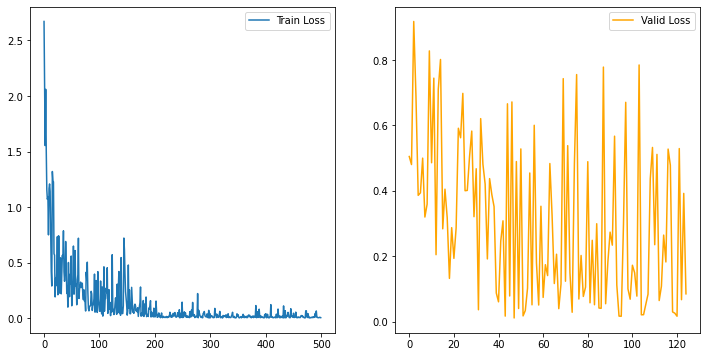

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


## Visualization to help understanding

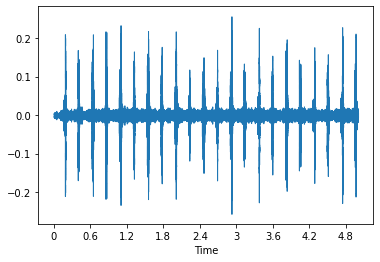

In [7]:
import librosa
import librosa.display
valid = valid_data.df
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('ESC50/ESC-50-master/audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr=sr)

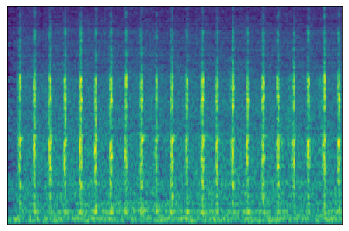

In [9]:
from datasets import spec_to_image, get_melspectrogram_db
librosa.display.specshow(spec_to_image(get_melspectrogram_db('ESC50/ESC-50-master/audio/'+filename, sr)), cmap='viridis')